In [1]:
! pip show numpy
! pip show scipy

Name: numpy
Version: 1.15.1
Summary: NumPy: array processing for numbers, strings, records, and objects.
Home-page: http://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages
Requires: 
Required-by: xgboost, tf-nightly-2.0-preview, tensorflowjs, tensorflow, tensorflow-hub, tensorboard, tb-nightly, statsmodels, scipy, patsy, pandas, opt-einsum, moviepy, matplotlib, Keras, Keras-Preprocessing, Keras-Applications, imageio, h5py, gensim
Name: scipy
Version: 1.3.1
Summary: SciPy: Scientific Library for Python
Home-page: https://www.scipy.org
Author: None
Author-email: None
License: BSD
Location: /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages
Requires: numpy
Required-by: xgboost, statsmodels, Keras, gensim


In [2]:
import numpy as np

def load_csv_to_ndarray(filepath):
    # Read using numpy lib and return all rows, no header in this case
    return np.genfromtxt(filepath, dtype=float, delimiter=',')

def transform_feature(one_dim_feature_vector):
    transformed_feature_vector = np.zeros((len(one_dim_feature_vector), 2*128))
    
    for i in range(0, len(one_dim_feature_vector)):
        feature = one_dim_feature_vector[i]
        transformed_feature = np.zeros(2*128)
        
        for j in range(0, 128):
            transformed_feature[2*j] = np.cos((j+1) * feature)
            
            transformed_feature[(2*j)+1] = np.sin((j+1) * feature)
        
        transformed_feature_vector[i] = transformed_feature
        
    return transformed_feature_vector

def add_weights_to_norm(covariance_matrix):
    # Shape (256,)
    weights = np.zeros(2*128)
    
    for j in range(0, 128):
        weights[2*j] = np.ceil((j+1)/2) ** 2 # Represent ceil(j/2) squared
        weights[(2*j)+1] = np.ceil((j+1)/2) ** 2 # Represent ceil(j/2) squared
        
#     identity_matrix = np.identity(2*128)
        
    return covariance_matrix + np.diag(weights)

def create_weights_diagonal_matrix(squared=False):
    # Shape (256,)
    weights = np.zeros(2*128)
    
    for j in range(0, 128):
        weights[2*j] = np.ceil((j+1)/2)
        if squared:
            weights[2*j] = weights[2*j] ** 2
            
        weights[(2*j)+1] = np.ceil((j+1)/2)
        if squared:
            weights[(2*j)+1] = weights[(2*j)+1] ** 2
        
    return weights, np.diag(weights) 

# Main training function, basically following this equation:
# b = inverse(X'X)X'y where:
# 1. b -> the params we seek
# 2. X -> feature matrix from train data (X' denotes the transpose)
# 3. y -> label from train data
def compute_solution(feature_matrix, label_vector):
    # Get X'
    feature_matrix_transposed = feature_matrix.T

    # Compute X'X
    feature_matrix_matmul = np.dot(feature_matrix_transposed, feature_matrix)

    # Compute inverse(X'X), assuming X'X matrix is invertible (there is unique solution)
    inverse_matmul = np.linalg.inv(feature_matrix_matmul)

    # Compute inverse(X'X)X'y
    return np.dot(np.dot(inverse_matmul, feature_matrix_transposed), label_vector)

# Main training function, basically following this equation:
# b = inverse(X'X)X'y where:
# 1. b -> the params we seek
# 2. X -> feature matrix from train data (X' denotes the transpose)
# 3. y -> label from train data
def compute_min_euclidean_norm_solution(feature_matrix, label_vector, weighted=False):
    # Get X'
    feature_matrix_transposed = feature_matrix.T

    # Compute X'X
    if weighted:
        feature_matrix_matmul = add_weights_to_norm(np.dot(feature_matrix_transposed, feature_matrix))
    else:
        feature_matrix_matmul = np.dot(feature_matrix_transposed, feature_matrix)
    
    # Basically, lstsq(M_1, M_2) will return a solution, let say M_sol
    # M_sol has the least squares/l2 norms amongst other solutions (there can also be no solution)
    # M_sol fulfills the equation: np.dot(M_1, M_sol) = M_2
    # In our case, M_1 would be X'X, M_2 would be X'y and M_sol would be the b we seek
    return np.linalg.lstsq(feature_matrix_matmul, np.dot(feature_matrix_transposed, label_vector), rcond=None)[0]

In [3]:
from helper import load_csv_to_ndarray

train_df = load_csv_to_ndarray('hw3p1_train.csv')
test_df = load_csv_to_ndarray('hw3p1_test.csv')

print(train_df.shape)
print(train_df[0:10])
print(test_df.shape)

(32, 2)
[[-3.0434  -0.08125]
 [-2.8439   1.3188 ]
 [-2.6444  -2.6813 ]
 [-2.4449   0.31875]
 [-2.2454  -0.28125]
 [-2.0458  -1.6812 ]
 [-1.8463  -0.88125]
 [-1.6468  -0.28125]
 [-1.4473   2.9187 ]
 [-1.2478   2.1187 ]]
(2079,)


In [4]:
one_dim_feature_vector = train_df[:,0]
label_vector = train_df[:,1]
print(one_dim_feature_vector.shape)
print(one_dim_feature_vector[0:10])
print(label_vector.shape)
print(label_vector[0:10])

(32,)
[-3.0434 -2.8439 -2.6444 -2.4449 -2.2454 -2.0458 -1.8463 -1.6468 -1.4473
 -1.2478]
(32,)
[-0.08125  1.3188  -2.6813   0.31875 -0.28125 -1.6812  -0.88125 -0.28125
  2.9187   2.1187 ]


In [5]:
feature_matrix = transform_feature(one_dim_feature_vector)
feature_matrix.shape

(32, 256)

In [6]:
sol = compute_solution(feature_matrix, label_vector)
min_sol = compute_min_euclidean_norm_solution(feature_matrix, label_vector)

print(sol[0:10])
print(min_sol[0:10])

[-59.60299856 -44.15723826  41.38379147 104.31027764  40.36524073
  -8.78692074 107.85389837 -31.06000114  85.56124849  15.50110649]
[ 0.04908832 -0.00718577 -0.03461254 -0.02689775 -0.03677315  0.02500117
  0.01177851  0.07089182 -0.01637569  0.00126613]


In [7]:
print(np.dot(feature_matrix, sol)[0:10])
print(np.dot(feature_matrix, min_sol)[0:10])

[  86.92821976   -8.96440367  -59.76711266  -23.61278954  -17.55202392
  -90.24015029   -1.4284046  -244.58954123   -1.70781486  -13.04720415]
[-0.08125  1.3188  -2.6813   0.31875 -0.28125 -1.6812  -0.88125 -0.28125
  2.9187   2.1187 ]


In [8]:
print(np.dot(feature_matrix, min_sol) - label_vector)

[-2.02615702e-15 -3.55271368e-15  1.33226763e-15 -1.11022302e-16
 -2.33146835e-15  2.66453526e-15  5.55111512e-16 -6.10622664e-16
 -5.32907052e-15 -4.88498131e-15  5.32907052e-15  4.44089210e-16
 -1.05471187e-15  1.66533454e-16  4.44089210e-16 -1.11022302e-15
 -1.94289029e-15 -1.77635684e-15 -6.66133815e-16 -2.88657986e-15
  1.74860126e-15 -4.44089210e-16  1.37390099e-15 -2.22044605e-16
 -9.29811783e-16 -8.88178420e-16  1.31838984e-15 -1.11022302e-15
 -4.99600361e-16  6.66133815e-16  2.22044605e-16 -1.99840144e-15]


In [9]:
print(np.dot(feature_matrix, sol) - label_vector)

[  87.00946976  -10.28320367  -57.08581266  -23.93153954  -17.27077392
  -88.55895029   -0.5471546  -244.30829123   -4.62651486  -15.16590415
    9.04683625  -19.84196194 -141.06795924 -142.25688386 -135.20616924
  155.33640414   -3.50841783   12.02666671  -25.36821526   16.77993084
  -11.73825187  122.69196297   79.05905586   43.5237401   -21.12346481
   84.41370859  -60.24274626  -32.49898985 -196.14458683  -50.12876986
   39.99042688   33.3560475 ]


In [10]:
test_feature_matrix = transform_feature(test_df)
print(test_feature_matrix.shape)

test_pred_result = np.dot(test_feature_matrix, min_sol)
print(test_pred_result.shape)

(2079, 256)
(2079,)


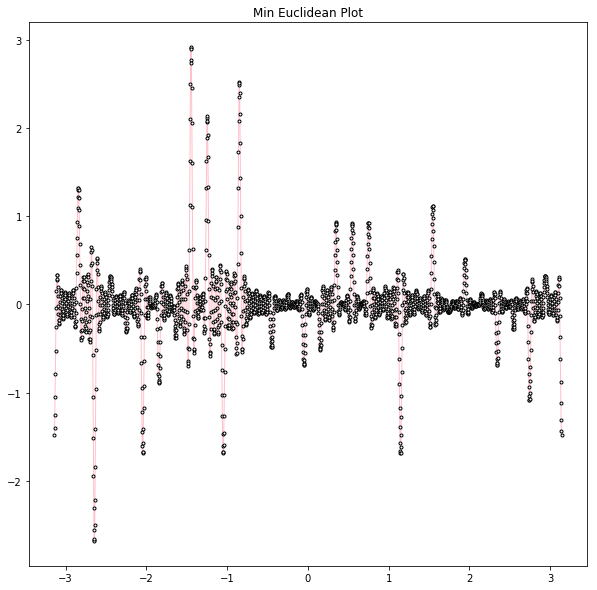

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.title('Min Euclidean Plot')

# for i in range(0, len(test_df)):
#     plt.plot(test_df[i:i+2], test_pred_result[i:i+2], 'ro-', color='black')

plt.plot(test_df, test_pred_result, color='pink', linewidth=1, marker='o', markersize=3, mfc='white', mec='black')

# plt.scatter(test_df, test_pred_result, color='black', s=np.full(2079, 10))

plt.show()

In [12]:
weighted_min_sol = compute_min_euclidean_norm_solution(feature_matrix, label_vector, True)

In [13]:
print(np.dot(feature_matrix, weighted_min_sol) - label_vector)

[-0.21446767 -1.0029611   1.3066666  -0.5565023  -0.19277294  0.48519983
  0.16357536  0.42608296 -1.00878131 -0.61722473  1.45082296 -1.18894001
  0.18868128  0.26110158 -0.20246542  0.23954608  0.27868055 -0.30719998
 -0.19715184 -0.26470466 -0.13239285  0.74827121 -0.14843482 -0.4722137
  0.33160853 -0.17317977 -0.10262321  0.27136428 -0.13801537  0.35423028
 -0.51149098  0.68714138]


In [14]:
c1 = np.dot(feature_matrix.transpose(), feature_matrix) + np.identity(256)

In [15]:
c2 = np.dot(feature_matrix.transpose(), label_vector)

In [16]:
inv_c1 = np.linalg.inv(c1)

In [17]:
min_sol_2 = np.dot(inv_c1, c2) 

In [18]:
min_sol_2[0:10]

array([ 0.04874669, -0.00713521, -0.03437277, -0.02670942, -0.03648349,
        0.0248028 ,  0.01168478,  0.07033452, -0.01624532,  0.00125532])

In [19]:
min_sol[0:10]

array([ 0.04908832, -0.00718577, -0.03461254, -0.02689775, -0.03677315,
        0.02500117,  0.01177851,  0.07089182, -0.01637569,  0.00126613])

In [20]:
print(np.dot(feature_matrix, min_sol_2) - label_vector)

[ 0.00012387 -0.01104883  0.02047247 -0.00305136  0.00183661  0.0130771
  0.00699649  0.00247518 -0.02256048 -0.01615112  0.01382025 -0.01928311
 -0.00045617  0.00415699 -0.00069533  0.00548697  0.0038207  -0.00725495
 -0.00726007 -0.00722443 -0.0008603   0.01338651 -0.00072527 -0.00857496
  0.00086095 -0.00393021 -0.00089551  0.00525088  0.00192606  0.008057
 -0.00310716  0.01097686]


In [21]:
print(np.max(np.dot(feature_matrix, min_sol) - label_vector))

5.329070518200751e-15


In [22]:
min_sol_2[abs(min_sol_2) < 1.e-15] = 0

In [23]:
import collections
collections.Counter(min_sol_2)[0]

0

In [24]:
weighted_min_sol[abs(weighted_min_sol) < 1.e-15] = 0
collections.Counter(weighted_min_sol)[0]

0

In [25]:
np.min(weighted_min_sol)

-0.27652128860528635

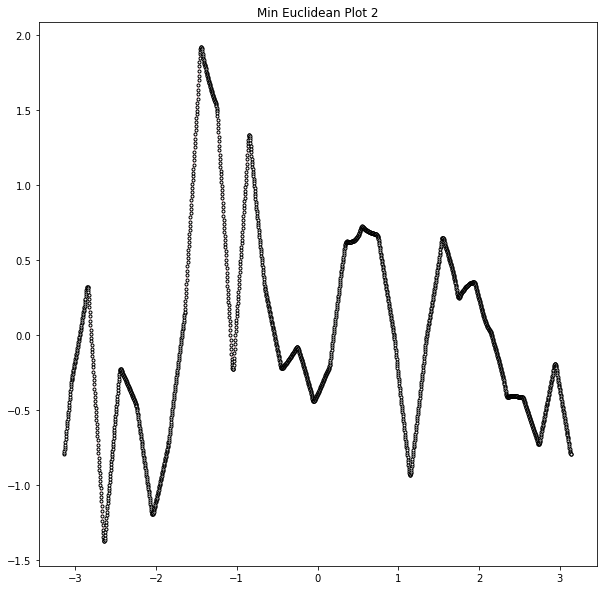

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

w_test_pred_result = np.dot(test_feature_matrix, weighted_min_sol)

fig = plt.figure(figsize=(10, 10))
plt.title('Min Euclidean Plot 2')

# for i in range(0, len(test_df)):
#     plt.plot(test_df[i:i+2], test_pred_result[i:i+2], 'ro-', color='black')

plt.plot(test_df, w_test_pred_result, color='pink', linewidth=1, marker='o', markersize=3, mfc='white', mec='black')

# plt.scatter(test_df, test_pred_result, color='black', s=np.full(2079, 10))

plt.show()

In [27]:
a, weights_diagonal_matrix = create_weights_diagonal_matrix()
print(a.shape)
print(a[0:5])
print(a[255])
print(weights_diagonal_matrix[0][0])
print(weights_diagonal_matrix[1][1])
print(weights_diagonal_matrix[2][2])
print(weights_diagonal_matrix[3][3])
print(weights_diagonal_matrix[4][4])
print(weights_diagonal_matrix[5][5])
print(weights_diagonal_matrix[255][255])

(256,)
[1. 1. 1. 1. 2.]
64.0
1.0
1.0
1.0
1.0
2.0
2.0
64.0


In [28]:
# Stack feature_matrix with weights_diagonal 
weighted_feature_matrix = np.vstack((feature_matrix, weights_diagonal_matrix))
# weighted_labels = np.dot()
weighted_feature_matrix.shape

(288, 256)

In [29]:
weighted_label_vector = np.zeros(2*128 + 32)
weighted_label_vector[0:32] = label_vector

In [30]:
weighted_min_sol_2 = compute_min_euclidean_norm_solution(weighted_feature_matrix, weighted_label_vector)
weighted_min_sol_2.shape

(256,)

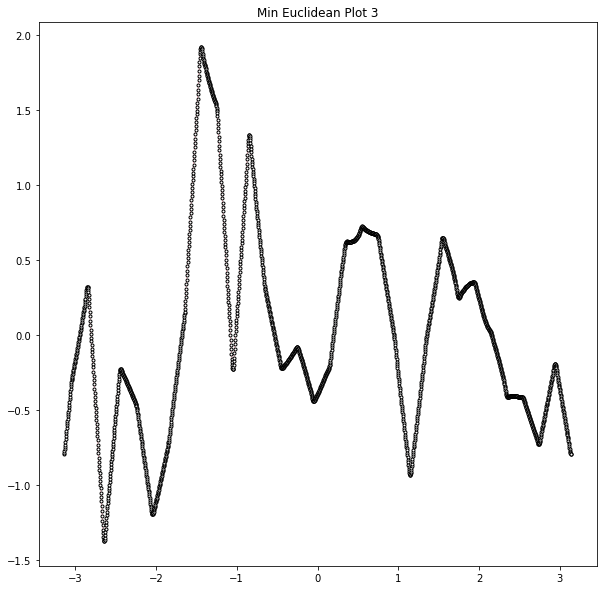

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

w_test_pred_result = np.dot(test_feature_matrix, weighted_min_sol_2)

fig = plt.figure(figsize=(10, 10))
plt.title('Min Euclidean Plot 3')

# for i in range(0, len(test_df)):
#     plt.plot(test_df[i:i+2], test_pred_result[i:i+2], 'ro-', color='black')

plt.plot(test_df, w_test_pred_result, color='pink', linewidth=1, marker='o', markersize=3, mfc='white', mec='black')

# plt.scatter(test_df, test_pred_result, color='black', s=np.full(2079, 10))

plt.show()

In [32]:
print(np.dot(feature_matrix, weighted_min_sol_2) - label_vector)

[-0.21446767 -1.0029611   1.3066666  -0.5565023  -0.19277294  0.48519983
  0.16357536  0.42608296 -1.00878131 -0.61722473  1.45082296 -1.18894001
  0.18868128  0.26110158 -0.20246542  0.23954608  0.27868055 -0.30719998
 -0.19715184 -0.26470466 -0.13239285  0.74827121 -0.14843482 -0.4722137
  0.33160853 -0.17317977 -0.10262321  0.27136428 -0.13801537  0.35423028
 -0.51149098  0.68714138]


In [35]:
print(np.dot(feature_matrix, min_sol) - label_vector)

[-2.02615702e-15 -3.55271368e-15  1.33226763e-15 -1.11022302e-16
 -2.33146835e-15  2.66453526e-15  5.55111512e-16 -6.10622664e-16
 -5.32907052e-15 -4.88498131e-15  5.32907052e-15  4.44089210e-16
 -1.05471187e-15  1.66533454e-16  4.44089210e-16 -1.11022302e-15
 -1.94289029e-15 -1.77635684e-15 -6.66133815e-16 -2.88657986e-15
  1.74860126e-15 -4.44089210e-16  1.37390099e-15 -2.22044605e-16
 -9.29811783e-16 -8.88178420e-16  1.31838984e-15 -1.11022302e-15
 -4.99600361e-16  6.66133815e-16  2.22044605e-16 -1.99840144e-15]
